# Kaggle Workflow using Pytorch: Kannada MNIST

## Table of Contents

1. [Getting Started](#Getting-Started)
    1. [Background](#Background)
    1. [Goal](#Goal)
    1. [Packages](#Packages)
1. [Meet and Greet Data](#Meet-and-Greet-Data,-Kaggle-Kannada-MNIST)
1. [Building and Training CNN Model](#Building-and-Training-CNN-Model)
1. [Training Session](#Training-Session)

---


## Getting Started

<img src="images/kannada_num.png" width=400 height=300></img>

### Background
Kannada is a language spoken predominantly by people of Karnataka in southwestern India. The language has roughly 45 million native speakers and is written using the Kannada script. [Wikipedia](https://en.wikipedia.org/wiki/Kannada)

The challenge faced by many industry and banking instances in India is to build a Optical Character Recognition that can detect Kannada digits from handwriting in cheques, written documents, etc to automate important task. By building a simple digit recognition, we can help many bussiness which application relies on reading handwritten digits, e.g. automating thousands of transaction from bank cheque validation.

A study in the paper of: Prabhu, Vinay Uday nicely captured the Kannada handwritten digits and the author has kindly shared with us the dataset we can experiment with. "Kannada-MNIST: A new handwritten digits dataset for the Kannada language." arXiv preprint [arXiv:1908.01242 (2019)](https://arxiv.org/abs/1908.01242).


### Goal
This tutorial will show you how to build a convolutional neural network using Pytorch. The dataset we are using is the [Kannada MNIST dataset](https://www.kaggle.com/c/Kannada-MNIST), a playground dataset from Kaggle. Here you can expect to get an insight about:
- Using Pytorch for data science modelling
- Get to know the workflow when participating in data science competition in [Kaggle](https://www.kaggle.com/) platform
- Understand about [Convolutional Neural Network](http://cs231n.stanford.edu/) for modelling Image Classification problem.

For more information about the PyTorch, please visit [Pytorch official website](https://pytorch.org/)

### Packages

We will also setup our project by specifying libraries and modules that we need

In [1]:
%%bash
pip3 install --quiet torchsummary

In [55]:
# standard library
import os, sys
import math
import json, logging, argparse

In [56]:
# data analytics library
import numpy as np
import pandas as pd

In [34]:
# Pytorch Library
import torch
import torch.nn as nn
import torch.distributed as dist
import torch.optim as optim
import torch.nn.functional as F

# Pytorch Utilities and Vision Library
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler

from torchvision import datasets, transforms
from torchsummary import summary

In [54]:
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [53]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Meet and Greet Data, Kaggle Kannada MNIST
_(Duration: 20 min)_

### Kannada MNIST Dataset Structure

![Kannada](images/kannada_banner.png)
 
#### From the official description:

The data files `train.csv` and `test.csv` contain gray-scale images of hand-drawn digits, from zero through nine, in the Kannada script.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, `train.csv`, has 785 columns. The first column, called label, is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixel$x$, where $x$ is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed $x$ as $x = i . 28 + j$, where i and $j$ are integers between 0 and 27, inclusive. Then pixel $x$ is located on row $i$ and column $j$ of a 28 x 28 matrix, (indexing by zero).

In addition to the main dataset, the author also disseminated an additional real world handwritten dataset (with 10k images), termed as the `Dig-MNIST dataset` that can serve as an out-of-domain test dataset. It was created with the help of volunteers that were non-native users of the language, authored on a smaller sheet and scanned with different scanner settings compared to the main dataset. This 'dig-MNIST' dataset serves as a more difficult test-set (An accuracy of 76.1% was reported in the paper cited above) and achieving ~98+% accuracy on this test dataset would be rather commendable.

In [4]:
data_dir = 'data/Kannada'

### Downloading Kaggle Dataset

In this workshop, we will quickly demonstrate how to download kaggle datasets into our jupyter environment. Kaggle has been and remains the de factor platform to try your hands on data science projects. The platform has huge rich free datasets for machine learning projects.

#### Step 1
Create a kaggle account if you do not have one already. Click on your user name, click on account.

<img src="images/kaggle_profile.png" width=400 height=250></img>

#### Step 2
Scroll down to click on create new API token. This will download a file unto your PC. Note the location of the downloaded file and move to the downloaded kaggle key file next to this notebook directory (just for convenience).
<img src="images/kaggle_api_cred.png" width=800 height=550></img>

#### Step3
Next we are going to use Kaggle API to download our Kannada MNIST dataset. The following cell contains bash command which will download our Kannada MNIST dataset to a folder called `data/Kannada/raw`. First we need to setup a few things before we make the API call.

- First, we will install kaggle client API using `$ pip3 install kaggle`. The flag `--quiet` is optional
- Then we create a directory called `~/.kaggle` which will be default folder to store our credential
- We then copy over our kaggle credential in kaggle.json to `~/.kaggle` directory so that kaggle API can find it

In [5]:
%%bash
## Install Kaggle CLI using Python Pip
pip3 install --quiet kaggle
mkdir -p ~/.kaggle

## Copy API key file to where Kaggle expects it
## Make sure to download the kaggle key file next to this notebook
cp kaggle.json ~/.kaggle/kaggle.json && chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Make user the Kaggle API credential is in ~/.kaggle/kaggle.json
! ls ~/.kaggle

kaggle.json


#### Step 4
Next we downloaded the data using Kaggle client and make an API call to stream the data. Once we receive the data, we unzip them into a folder we have prepared in `data/Kannada/raw`
- Using the credential, kaggle API will be able to authenticate us. Then the download begin when we run `$ kaggle competitions download -c Kannada-MNIST`
- Finally, we unzip the data once we finish the download to a folder called `data/Kannada/raw`

In [7]:
%%bash

## Download Kannada MNIST from Kaggle
kaggle competitions download -c Kannada-MNIST

## Create our data directory
mkdir -p data/Kannada/raw
mkdir -p data/Kannada/processed

## Unzip to data/Kannada directory
unzip Kannada-MNIST.zip -d data/Kannada/raw


Archive:  Kannada-MNIST.zip
  inflating: data/Kannada/raw/Dig-MNIST.csv  
  inflating: data/Kannada/raw/sample_submission.csv  
  inflating: data/Kannada/raw/test.csv  
  inflating: data/Kannada/raw/train.csv  


100%|██████████| 12.4M/12.4M [00:02<00:00, 6.32MB/s]


It's always a good practice to seperate raw data we just downloaded into a folder called 'raw'. Along the process, we will encounter a situation where we have pre-processed/cleaned our dataset and would like to store them seperately from the raw data.

Now let's check the content of our dataset in `raw` folder. We see several files here:

In [8]:
# Check the data folder content
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print('data at: ' + os.path.join(dirname, filename))

data at: data/Kannada/raw/sample_submission.csv
data at: data/Kannada/raw/train.csv
data at: data/Kannada/raw/test.csv
data at: data/Kannada/raw/Dig-MNIST.csv


### Dataset Files

There are 4 files we get after downloading the data from Kaggle. According to the official docs above, the files summary is as follows:
- `train.csv` - the training set. The first column of every row is the label, the rest 784 values in the same row is the pixel value of our image with flattened structure defined above.
- `Dig-MNIST.csv`: this is similar to image training set in `train.csv`. The contributor provide this set kindly to allow us to have a validation/testing set before we make a submission.
- `test.csv`: the submission set. Unlike the `train.csv` and `Dig-MNIST.csv` it doesn't come with label because it suppose to be our submission for the competition. We will refer data from this file as *submission set* from now on.
- `sample_submission.csv` - a sample submission file in the correct format

### Understanding the Data 

- We have training and test set CSV files,
- In order to evaluate the generalization skill of the model we will split our training set into training and validation.
- After training the data, Kaggle will evaluate the final performance of our data with test set predictions from `Dig-MNIST.csv`
- Then we will make a Kaggle submission from `test.csv` to Kaggle. Note that this dataset will not have labels and hence we can't make evaluation until we submit.

### Loading Dataset with Pandas

Let's read our dataset

In [9]:
from sklearn.model_selection import train_test_split

# # Load Data
train = pd.read_csv(os.path.join(data_dir, 'raw/train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'raw/Dig-MNIST.csv'))  # this will be our test set for evaluation
submission_set = pd.read_csv(os.path.join(data_dir, 'raw/test.csv')).iloc[:,1:]  # this set is only for submission

# # Seperate train data and labels
train_data = train.drop('label',axis=1)
train_targets = train['label']

# # Seperate test data and labels
test_images=test.drop('label',axis=1)
test_labels=test['label']

* We have $28$x$28$ dimension handwritten pics.
* Dataset has been already flattened and has 784-pixel values for each pic.
* Totaly we have $60000$ pics in training set.

In [11]:
# Reset Index
train_images.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)

val_images.reset_index(drop=True, inplace=True)
val_labels.reset_index(drop=True, inplace=True)

test_images.reset_index(drop=True, inplace=True)
test_labels.reset_index(drop=True, inplace=True)

#### Overview

Let's look at the content of the files. There are things to take note regarding our data:
- The content of our file is flattened image. Originally, each row was a 28 x 28 pixels image. 
- The each image is flattened into 784 row and saved into a `.csv` file. 
- The image itself is `Gray` image, which means it only has one channel 

In [48]:
train_images.head(10).iloc[:,490:520]

,pixel490,pixel491,pixel492,pixel493,pixel494,pixel495,pixel496,pixel497,pixel498,pixel499,...,pixel510,pixel511,pixel512,pixel513,pixel514,pixel515,pixel516,pixel517,pixel518,pixel519
0,0,0,207,16,0,0,0,0,0,0,...,0,0,0,0,239,0,0,0,0,0
1,0,0,0,0,217,12,0,0,0,0,...,0,0,0,0,43,217,0,0,0,0
2,0,0,0,0,96,255,0,0,0,0,...,0,0,0,159,159,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,180,185,0,0,0,0
4,65,0,0,0,0,0,0,0,0,0,...,0,0,0,0,255,35,0,0,0,0
5,140,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,7,86,142,0,0
6,255,255,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,255,0,255
7,0,16,32,32,32,32,109,255,0,0,...,0,0,0,0,167,147,0,0,0,112
8,0,0,0,0,182,146,0,0,0,0,...,0,0,146,182,0,0,0,0,0,0
9,0,0,0,0,114,43,0,0,0,0,...,0,0,17,230,169,32,10,216,0,0


### Visualising Dataset Distribution

* It is important to know the distribution of data according to the labels they have.
* This data set is __homogeneously__ distributed as you see below.

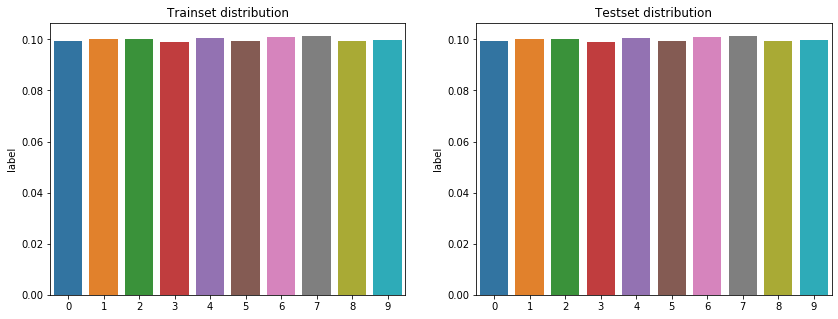

In [41]:
train_dist = train_labels.value_counts(normalize = True)
test_dist = test_labels.value_counts(normalize = True)
submission_dist = train_labels.value_counts(normalize = True)

dists_to_plot = [('Trainset', train_dist), ('Testset', submission_dist)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
colors = []

for i, (name, df) in enumerate(dists_to_plot):
    sns.barplot(x=df.index, y=df, ax=axes[i])
    axes[i].set_title(name + ' distribution');

### Cross Validation - Training - Validation - Test Split 

**Splitting training set to train and validation set** - In order to measure the generalization ability of the model, we train the data with the training set and make the model arrangement according to the error value in the validation set. In addition, we determine the final performance of the model with the test set.

This Kernel is prepared on a Kaggle competition dataset. They give us a training set for training the model and a test set without labels for prediction. As we don't have the labels we don't know the final performance of the test set until we submit our predictions.

**Why we need testing set? Isn't validation set enough?** - -The reason for using the test set on the final evaluation is the model would have a bias on the validation set because we developed the model according to the validation set performance. So a kind of overfitting on the validation set is formed. The testing set will be performed to further evaluate the model after validation set. As mentioned above, this is to check whether our modelling has been overfitted/biased toward the validation set. 

To evaluate the model better, we need to split our training set into training and validation set. We will use a testing set from `Dig-MNIST.csv` instead which has been prepared for the purpose of evaluation. 

Commonly, the prefered split for training set:
  * Training set -  $80$% 
  * Validation set -  $20$%

Now how do we split our training and validation set? For simple splitting scheme, we can borrow the functionality from `sklearn.model_selection.train_test_split` as follows. How about testing set? Well we already have it in `test_images` dataframe. Hence we only need to split on training set to train and validation set.

In [10]:
# Train Test Split for evaluation
train_images, val_images, train_labels, val_labels = train_test_split(train_data, 
                                                                     train_targets, 
                                                                     test_size=0.2)

After splitting, our dataset is organised as follows:

| Split      | Number of data | Shape of Image | Number of labels
| ---:       | ---:           | ---:           |  ---:
|Training    |  50000         |  1 x 28 x 28   |  51000
|Validation  |  10000         |  1 x 28 x 28   |  10000
|Training    |  10240         |  1 x 28 x 28   |  10240
|Training    |  5000          |  1 x 28 x 28   |  5000

In [52]:
print('Shape of training set   :', train_images.shape)
print('Shape of validation set :', val_images.shape)
print('Shape of testing set    :', test_images.shape)

print('Shape of submission set :', submission_set.shape)

Shape of training set   : (51000, 784)
Shape of validation set : (9000, 784)
Shape of testing set    : (10240, 784)
Shape of submission set : (5000, 784)


## Pytorch Dataset Object & Data Loader

A lot of effort in solving any machine learning problem goes in to preparing the data. PyTorch provides many tools to make data loading easy and hopefully, to make your code more readable. Let's see how we can simply to load and preprocess/augment data from our Kannada dataset.

### Define Pytorch Dataset Object

Now, our raw dataset originally came from a `.csv` format. This table is represented by `pd.DataFrame` object which support Microsoft-Excel-like functionality on table manipulation.

However, our Kannada dataset is meant to be an image, not table dataset. If you look carefully, our data is a flattened image pixels, stored in a row of a table. The problem here is that representing image with `pd.DataFrame` table is unheard off as we will find difficulties in performing image operations, e.g. filtering, rotation, and convolution.

Let's see how we can mitigate this problem, and automate them in Pytorch `Dataset object`.

In [19]:
class KannadaDataSet(Dataset):
    """ Representation of our Kannada Dataset as a whole.
    Scope of this object is to dictate how to access a single data/image and
    it's label from our datapool, then convert it to desired matrix format which represent
    an image.
    """
    def __init__(self, X, labels, transforms=None):
        """
        Arguments:
        --------------------
            .. X (pd.DataFrame): table representation of flattened Kannada image pixels
            .. labels (array-like): ground truth label of the digit. Ranging from digit 0 to digit 9
        """
        self.X = X
        self.labels = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X.iloc[i,:]
        data = np.array(data).astype(np.uint8).reshape(IMGSIZE,IMGSIZE,1)
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.labels is not None:
            # for train set, val set, and test set
            return (data, self.labels[i])
        else:
            # for kaggle submission
            # since submission set will not have labels
            return data

### Define Image Transformation Pipeline

As part of data science workflow, we will need to write some prepocessing code. One issue with our dataset right now is that it needs to be converted from `np.ndarray` matrix form to `torch.Tensor`. 

In addition to that, we would like to introduce several data augmentation, such as rotation, and translation to our image to increase the variety of our dataset. This is done so that our model sees more variety of data and more robust to the effect of image translation and rotation. 

Let's define three transform:
- **`ToPILImage`**: PIL Image representation allows image based operation. It's good to convert our matrix to PIL Image first
- **`RandomCrop`**: to crop from image randomly. This is data augmentation, which introduce translation
- **`RandomAffine`**: to rotate image randomly from -5 to 5 degrees. This is data augmentation
- **`ToTensor`**: to convert the numpy images to torch images (we need to swap axes).

In [20]:
IMGSIZE = 28

# Transformations for the train
train_trans = transforms.Compose(([
    transforms.ToPILImage(),
    transforms.RandomCrop(IMGSIZE),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    transforms.ToTensor(), # automatically divide pixels by 255
]))

# Transformations for the validation & test sets
val_trans = transforms.Compose(([
    transforms.ToPILImage(),
    transforms.ToTensor(), # automatically divide pixels by 255
]))

### Define Pytorch Data Loader

Loading data may take a few moments, and you should see your progress as the data is loading. You may also choose to increase the `batch_size` if you want to load more data at a time.

In [21]:
batch_size = 64

# Initialise dataset object for each set
train_data = KannadaDataSet(train_images, train_labels, train_trans)
val_data   = KannadaDataSet(val_images, val_labels, val_trans)
test_data  = KannadaDataSet(test_images, test_labels, val_trans)
submission_data = KannadaDataSet(submission_set, None, val_trans)

# Define Dataloader for each set
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_data, 
                        batch_size=batch_size, # batch_size=1000
                        shuffle=False)

test_loader = DataLoader(test_data,
                         batch_size=batch_size, # batch_size=1000
                         shuffle=False)

# for kaggle submission
submission_loader = DataLoader(submission_data,
                               batch_size=batch_size,
                               shuffle=False)

### Visualise Image in Training Batch

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

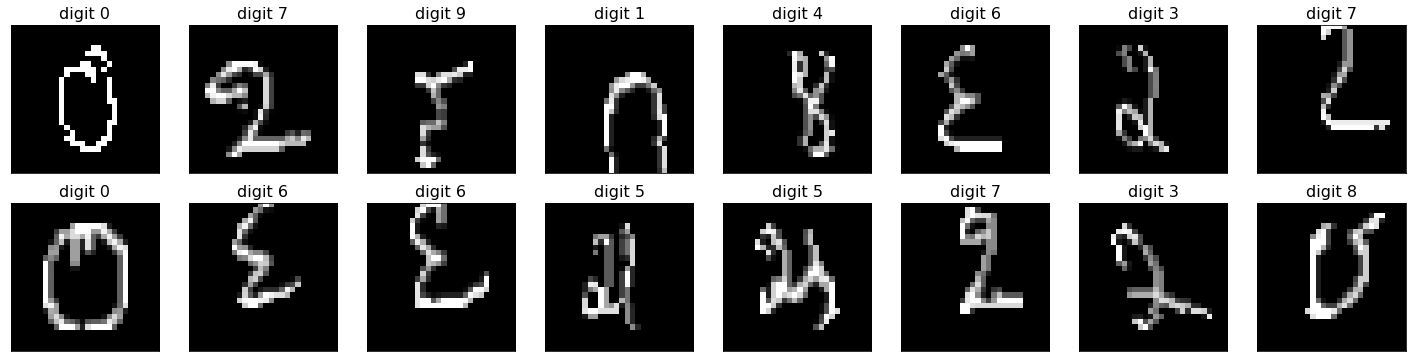

In [58]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 6))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title('digit ' + str(labels[idx].item()), fontsize=16)  # .item() gets single value in scalar tensor

### Visualise Image in Detail

Now let's see an image from MNIST dataset in detail. Notice how our image pixels only ranges from $(0, 1)$. This means that no further normalisation is required in the preprocessing step.

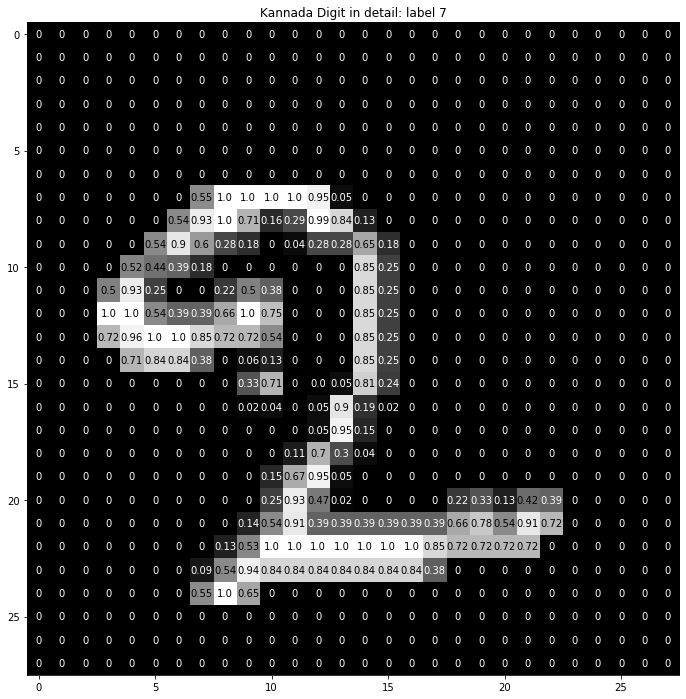

In [64]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5

for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

ax.set_title('Kannada Digit in detail: label %d' % labels[1].item());

### Saving Dataset Split

Now that we have done several splitting and preprocessing step, let's save our processed data that we have at this point to a seperate folder called `data/Kannada/processed`. This is a good practice so that the next time you would like to continue your work, you don't have to run the code from the beggining.

In [24]:
# Save data to local folder first
train_images.to_csv(os.path.join(data_dir, 'processed/train.csv'), index=False, header=False)
train_labels.to_csv(os.path.join(data_dir, 'processed/train_labels.csv'), index=False, header=False)

val_images.to_csv(os.path.join(data_dir, 'processed/validation.csv'), index=False, header=False)
val_labels.to_csv(os.path.join(data_dir, 'processed/validation_labels.csv'), index=False, header=False)

test_images.to_csv(os.path.join(data_dir, 'processed/test.csv'), index=False, header=False)
test_labels.to_csv(os.path.join(data_dir, 'processed/test_labels.csv'), index=False, header=False)

submission_set.to_csv(os.path.join(data_dir, 'processed/submission_test.csv'), index=False, header=False)

---

# Building and Training CNN Model
_(Duration: 25 min)_

On building stage you specify the architecture of the model mainly.

You can decide the Filter size and Padding type you will use on Convolution operations and add Pooling, Batch Normalization, Dropout, activation function layers with build section.


In [24]:
class KannadaCNN(nn.Module):
    """ Simple Convolutional Neural Network to classify 
    Kannada handwritten digit
    """
    def __init__(self, drop_p=0.4, num_classes=10):
        """ Initialise and build network layers 
        Arguments
        --------------------
            .. drop_p (float, range[0, 1.]): constant probability in our dropout layer
            .. num_classes (int): number of target classes in our data
        """
        super().__init__()
        self.num_classes = num_classes
        
        # First hidden layer
        self.conv2d_0 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.convbn_0 = nn.BatchNorm2d(num_features=64)

        self.conv2d_1 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.convbn_1 = nn.BatchNorm2d(num_features=64)

        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop_1 = nn.Dropout2d(p=drop_p)

        # Second hidden layer
        self.conv2d_2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.convbn_2 = nn.BatchNorm2d(num_features=128)

        self.conv2d_3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.convbn_3 = nn.BatchNorm2d(num_features=128)

        self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop_2 = nn.Dropout2d(p=drop_p)

        # Third hidden layer
        self.conv2d_4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.convbn_4 = nn.BatchNorm2d(num_features=256)
        
        self.conv2d_5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.convbn_5 = nn.BatchNorm2d(num_features=256)

        self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop_3 = nn.Dropout(p=drop_p)

        # Dense fully connected layer
        self.dense_linear_1 = nn.Linear(256*3*3, 512)
        self.drop_4 = nn.Dropout(p=drop_p)

        self.dense_linear_2 = nn.Linear(512, 256)
        self.drop_5 = nn.Dropout(p=drop_p)

        self.dense_linear_3 = nn.Linear(256, 128)
        self.out_layer = nn.Linear(128, num_classes)

    def forward(self, x):
        """ Define the feed-forward flow of our neural network
        """

        x = self.conv2d_0(x)
        x = self.convbn_0(x)
        x = F.leaky_relu(x)
        
        x = self.conv2d_1(x)
        x = self.convbn_1(x)
        x = F.leaky_relu(x)

        x = self.pool_1(x)
        x = self.drop_1(x)

        x = self.conv2d_2(x)
        x = self.convbn_2(x)
        x = F.leaky_relu(x)

        x = self.conv2d_3(x)
        x = self.convbn_3(x)
        x = F.leaky_relu(x)

        x = self.pool_2(x)
        x = self.drop_2(x)

        x = self.conv2d_4(x)
        x = self.convbn_4(x)
        x = F.leaky_relu(x)
        
        x = self.conv2d_5(x)
        x = self.convbn_5(x)
        x = F.leaky_relu(x)
        
        x = self.pool_3(x)
        x = self.drop_3(x)

        x = x.view(-1, 256*3*3)
        x = self.dense_linear_1(x)
        x = F.relu(x)
        x = self.drop_4(x)
        
        x = self.dense_linear_2(x)
        x = F.relu(x)
        x = self.drop_5(x)
        
        x = self.dense_linear_3(x)
        x = F.relu(x)

        out = self.out_layer(x)
        return out

### Construct Neural Network from Pytorch Model Class

Now that we have defined our CNN model class using `nn.Module` and added the all layers, let's make it come to life by constructing the object so that we can use it to make prediction.

In [25]:
# Constructing our CNN module
model = KannadaCNN().to(device)
# initialise network
net = KannadaCNN().to(device)

# optimiser
optimiser = optim.Adam(net.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()

# display model summary
summary(model, input_size=(1,IMGSIZE,IMGSIZE))  # IMGSIZE = 28

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,664
       BatchNorm2d-2           [-1, 64, 28, 28]             128
            Conv2d-3           [-1, 64, 28, 28]         102,464
       BatchNorm2d-4           [-1, 64, 28, 28]             128
         MaxPool2d-5           [-1, 64, 14, 14]               0
         Dropout2d-6           [-1, 64, 14, 14]               0
            Conv2d-7          [-1, 128, 14, 14]          73,856
       BatchNorm2d-8          [-1, 128, 14, 14]             256
            Conv2d-9          [-1, 128, 14, 14]         147,584
      BatchNorm2d-10          [-1, 128, 14, 14]             256
        MaxPool2d-11            [-1, 128, 7, 7]               0
        Dropout2d-12            [-1, 128, 7, 7]               0
           Conv2d-13            [-1, 256, 7, 7]         295,168
      BatchNorm2d-14            [-1, 25

---

## Training Session

Now let's fit our convolutional neural network by using our training set. For every epoch, we will evaluate the performance of our network on validation set and monitor the result. Finally, we perform one more evaluation on our testing set to make sure our setup is not biased towards our validation set.

#### Evaluation Metric
We define a function to help calculate the accuracy metric.

$$ \text{Accuracy} = \frac{\text{Number of Correct Prediction}}{\text{Number of all images in Dataset}}
$$

In [26]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

#### Modelling Fitting

Let's define how our training looks like when we fit and run our network to learn on data.

1. First we load our data per mini-batch
2. Perform lightweight data preprocessing/transformation (under the hood of `torch.DataLoader`)
3. Feed forward data to our `CNN`. Let it classify which digit does the image belongs to. Our network make a guess by outputing a probability for each class.
4. Calculate the error/loss based on groun truth and our `CNN` prediction.
5. Perform gradient descent, optimise weights and parameters update in our `CNN` so that next time, it can learn and make better guess.

In [27]:
def train_helper(train_loader, model, optimizer, criterion,
                  epoch, device='cpu', log_interval=25):
    # set to training mode
    model.train()

    # training result to record
    train_loss = 0.0
    train_top1 = 0.0
    train_top5 = 0.0

    for batch_idx, (data, target) in enumerate(train_loader, start=1):
        # convert tensor for current runtime device
        data, target = data.to(device), target.to(device)

        # reset optimiser gradient to zero
        optimizer.zero_grad()

        # feed forward
        out = model(data)
        
        # calculate loss and optimise network params
        loss = criterion(out, target)
        loss.backward()
        
        # optimize weight to account for loss/gradient
        optimizer.step()

        # calculate training accuracy for top1 and top5
        top1, top5 = accuracy(out, target, topk=(1,5))

        # update result records
        train_top1 += top1.item()
        train_top5 += top5.item()
        train_loss += loss.item()

        # logging loss output to stdout
        if batch_idx % log_interval == 0:
            print('Train Epoch: {:03d} [{:05d}/{:05d} ({:2.0f}%)] | '
                  'Top1 Acc: {:4.1f} \t| Top5 Acc: {:4.1f} \t| Loss: {:.4f}'
                  .format(epoch, batch_idx * len(data), len(train_loader.sampler),
                      100 * batch_idx / len(train_loader),
                      top1, top5, loss.item()))

    # display training result
    train_loss /= len(train_loader.dataset)
    train_top1 /= len(train_loader) # average loss over mini-batches
    train_top5 /= len(train_loader) # average loss over mini-batches

    print('Training Summary Epoch: {:03d} | '
          'Average Top1 Acc: {:.2f}  | Average Top5 Acc: {:.2f} | Loss: {:.4f}'
          .format(epoch, train_top1, train_top5, train_loss))
    
    return train_loss, train_top1, train_top5 

#### Modelling Evaluation

For both validation and testing, the flow will be the same except that we use different images from different set/split.

1. First we load our data per mini-batch
2. Perform lightweight data preprocessing/transformation (under the hood of `torch.DataLoader`)
3. Feed forward data to our `CNN`. Let it classify which digit does the image belongs to. Our network make a guess by outputing a probability for each class.
4. Calculate the error/loss, top1 accuracy, and top5 accuracy as our evaluation metric

In [28]:
def test_helper(test_loader, model, criterion, 
                 epoch, device='cpu'):
    # set to validation mode
    model.eval()
    
    test_loss = 0.0  # record testing loss
    test_top1 = 0.0
    test_top5 = 0.0
    for batch_idx, (data, target) in enumerate(test_loader, start=1):

        # convert tensor for current runtime device
        data, target = data.to(device), target.to(device)

        # generate image x
        out = model(data)

        # calculate loss and optimise network params
        loss = criterion(out, target)
        
        # calculate testing accuracy for top1 and top5
        top1, top5 = accuracy(out, target, topk=(1,5))

        # update test loss
        test_top1 += top1.item()
        test_top5 += top5.item()
        test_loss += loss.item()

    # display validation/testing result
    test_loss /= len(test_loader.dataset)  # average loss over all images
    test_top1 /= len(test_loader)
    test_top5 /= len(test_loader)

    print('Test Summary Epoch: {:03d} | '
          'Average Top1 Acc: {:.2f}  | Average Top5 Acc: {:.2f} | Loss: {:.4f}'
          .format(epoch, test_top1, test_top5, test_loss))
    
    return test_loss, test_top1, test_top5

#### Running Complete Train Session

Finally, combining the training and model evaluation in our flow, we will run the model for several epochs. Below are several training **hyperparameters** you need to be aware of

- **`epochs`** : Number of times our `CNN` will see the training data
- **`batch size`**: Often called mini-batchsize as well.

In [29]:
# ----------------------------
# COMPLETE TRAINING SESSION
# ----------------------------

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

for epoch in range(1, 2 + 1):
    print('\n' + '-' * 100)
    # run session on training set
    train_loss, train_acc, _  = train_helper(train_loader, net, optimiser, criterion,
                                              epoch=epoch, device=device, log_interval=100)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # run session on validation set
    val_loss, val_acc, _ = test_helper(val_loader, net, criterion, epoch, device=device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# finally, run session testing set
print('\n' + 'Final Test Set Result:\n'+ '*' * 80)
test_helper(test_loader, net, criterion, epoch, device=device);


----------------------------------------------------------------------------------------------------
Train Epoch: 001 [06400/51000 (13%)] | Top1 g Acc: 78.1 	| Top5 Acc: 100.0 	| Loss: 0.5618
Train Epoch: 001 [12800/51000 (25%)] | Top1 g Acc: 95.3 	| Top5 Acc: 100.0 	| Loss: 0.1932
Train Epoch: 001 [19200/51000 (38%)] | Top1 g Acc: 100.0 	| Top5 Acc: 100.0 	| Loss: 0.0600
Train Epoch: 001 [25600/51000 (50%)] | Top1 g Acc: 96.9 	| Top5 Acc: 100.0 	| Loss: 0.1325
Train Epoch: 001 [32000/51000 (63%)] | Top1 g Acc: 96.9 	| Top5 Acc: 100.0 	| Loss: 0.0719
Train Epoch: 001 [38400/51000 (75%)] | Top1 g Acc: 98.4 	| Top5 Acc: 100.0 	| Loss: 0.0625
Train Epoch: 001 [44800/51000 (88%)] | Top1 g Acc: 98.4 	| Top5 Acc: 100.0 	| Loss: 0.0861
Training Summary Epoch: 001 | Average Top1 Acc: 89.05  | Average Top5 Acc: 98.13 | Loss: 0.0049
Val/Test Summary Epoch: 001 | Average Top1 Acc: 98.50  | Average Top5 Acc: 99.94 | Loss: 0.0009

-------------------------------------------------------------------

### Visualise Training Session results

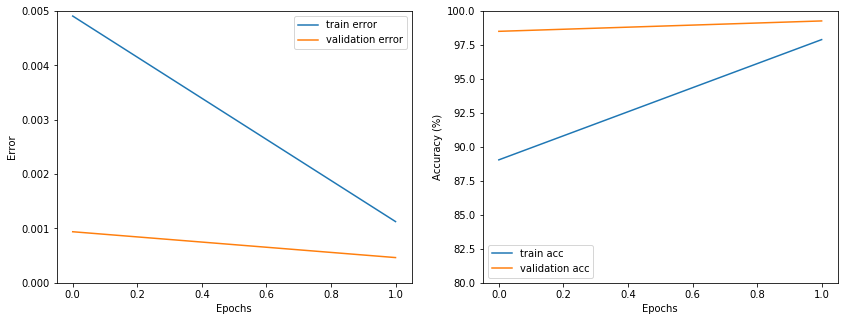

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Plot Error training vs validation
axes[0].plot(train_losses);
axes[0].plot(val_losses);

axes[0].set_ylabel('Error');
axes[0].set_xlabel('Epochs');

axes[0].set_ylim(0, 0.005);
axes[0].legend(labels=['train error', 'validation error']);

# Plot Accuracy training vs validation
axes[1].plot(train_accuracies);
axes[1].plot(val_accuracies);

axes[1].set_ylabel('Accuracy (%)');
axes[1].set_xlabel('Epochs');

axes[1].set_ylim(80, 100);
axes[1].legend(labels=['train acc', 'validation acc']);

### Writing Submission to Kaggle Competition

In [31]:
# Time to get the network's predictions on the test set
# Put the test set in a DataLoader

net.eval() # Safety first
predictions = torch.LongTensor().to(device) # Tensor for all predictions

# Go through the test set, saving the predictions in... 'predictions'
for images in submission_loader:
    images = images.to(device)
    preds = net(images)
    predictions = torch.cat((predictions, preds.argmax(dim=1)), dim=0)

In [32]:
submission_pred_df = pd.DataFrame(predictions.cpu().detach().numpy())

In [33]:
submission_pred_df.to_csv(os.path.join(data_dir, 'kannada_sub_baseline.csv'), 
                          index=True, index_label='id', header=['label'])